Predicting housing prices given the data set from and following https://www.geeksforgeeks.org/machine-learning/house-price-prediction-using-machine-learning-in-python/

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

dataset = pd.read_excel('../data/HousePricePrediction.xlsx')
print(dataset.head(5))
print(f'There are {dataset.shape[0]} rows and {dataset.shape[1]} columns in the dataset.')

   Id  MSSubClass MSZoning  LotArea LotConfig BldgType  OverallCond  \
0   0          60       RL     8450    Inside     1Fam            5   
1   1          20       RL     9600       FR2     1Fam            8   
2   2          60       RL    11250    Inside     1Fam            5   
3   3          70       RL     9550    Corner     1Fam            5   
4   4          60       RL    14260       FR2     1Fam            5   

   YearBuilt  YearRemodAdd Exterior1st  BsmtFinSF2  TotalBsmtSF  SalePrice  
0       2003          2003     VinylSd         0.0        856.0   208500.0  
1       1976          1976     MetalSd         0.0       1262.0   181500.0  
2       2001          2002     VinylSd         0.0        920.0   223500.0  
3       1915          1970     Wd Sdng         0.0        756.0   140000.0  
4       2000          2000     VinylSd         0.0       1145.0   250000.0  
There are 2919 rows and 13 columns in the dataset.


In [2]:
# data preprocessing
obj = (dataset.dtypes == 'object')
object_cols = list(obj[obj].index)
print(f'There are {len(object_cols)} categorical variables, ')

int_ = (dataset.dtypes == 'int')
num_cols = list(int_[int_].index)
print(f' {len(num_cols)} integer variables, and')

fl = (dataset.dtypes == 'float')
fl_cols = list(fl[fl].index)
print(f' {len(fl_cols)} float variables.')

There are 4 categorical variables, 
 6 integer variables, and
 3 float variables.


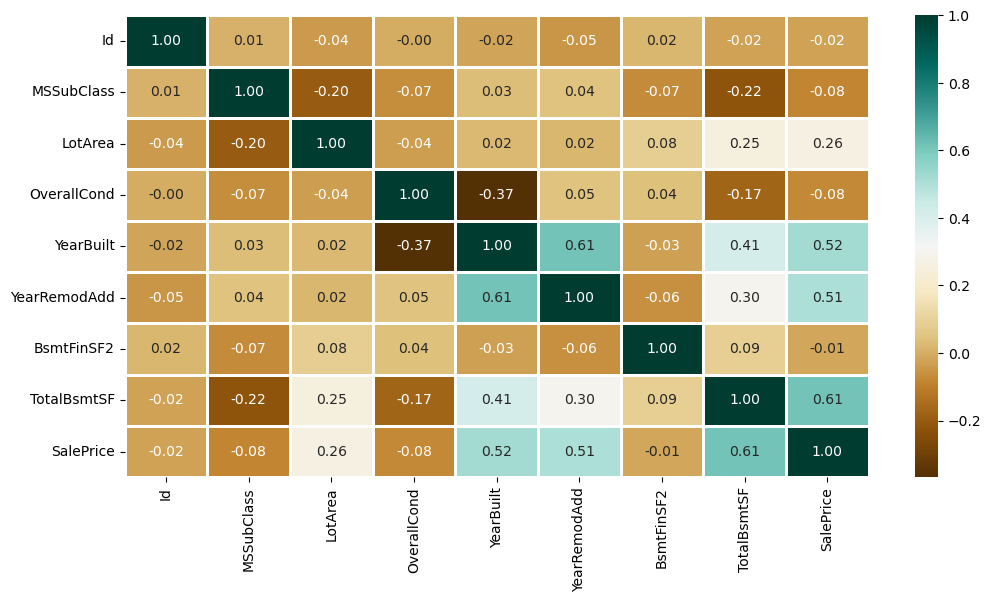

In [3]:
# exploratory data analysis
numerical_dataset = dataset.select_dtypes(include=['number'])

plt.figure(figsize=(12,6))
sns.heatmap(numerical_dataset.corr(),
            cmap = 'BrBG',
            fmt = '.2f',
            linewidths = 2,
            annot = True)

plt.savefig('../results/figures/edaHeatmap.png', dpi=300, bbox_inches='tight')
plt.show()

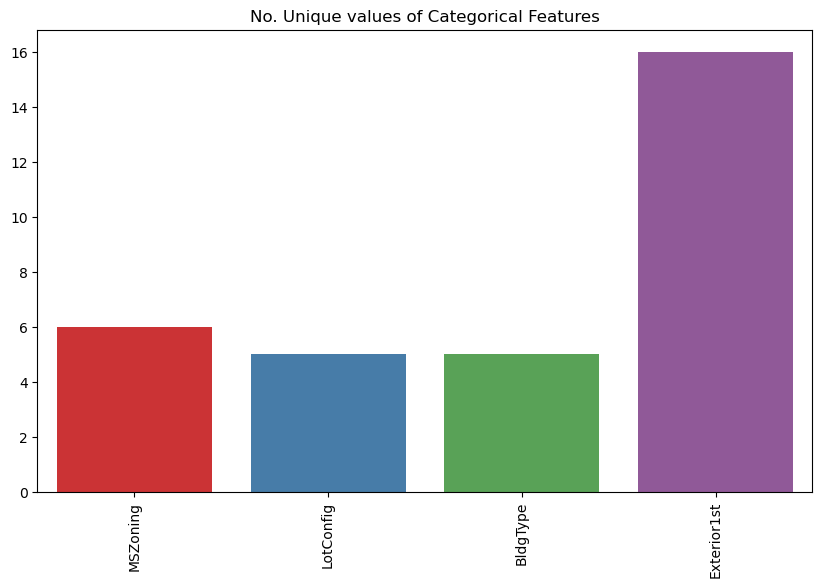

In [4]:
# number of unique values of categorical features
unique_values = []
for col in object_cols:
    unique_values.append(dataset[col].unique().size)
plt.figure(figsize=(10,6))
plt.title('No. Unique values of Categorical Features')
plt.xticks(rotation=90)
sns.barplot(x=object_cols,y=unique_values, hue=object_cols, palette='Set1', legend=False)

plt.savefig('../results/figures/edaBarplot.png', dpi=300, bbox_inches='tight')
plt.show()

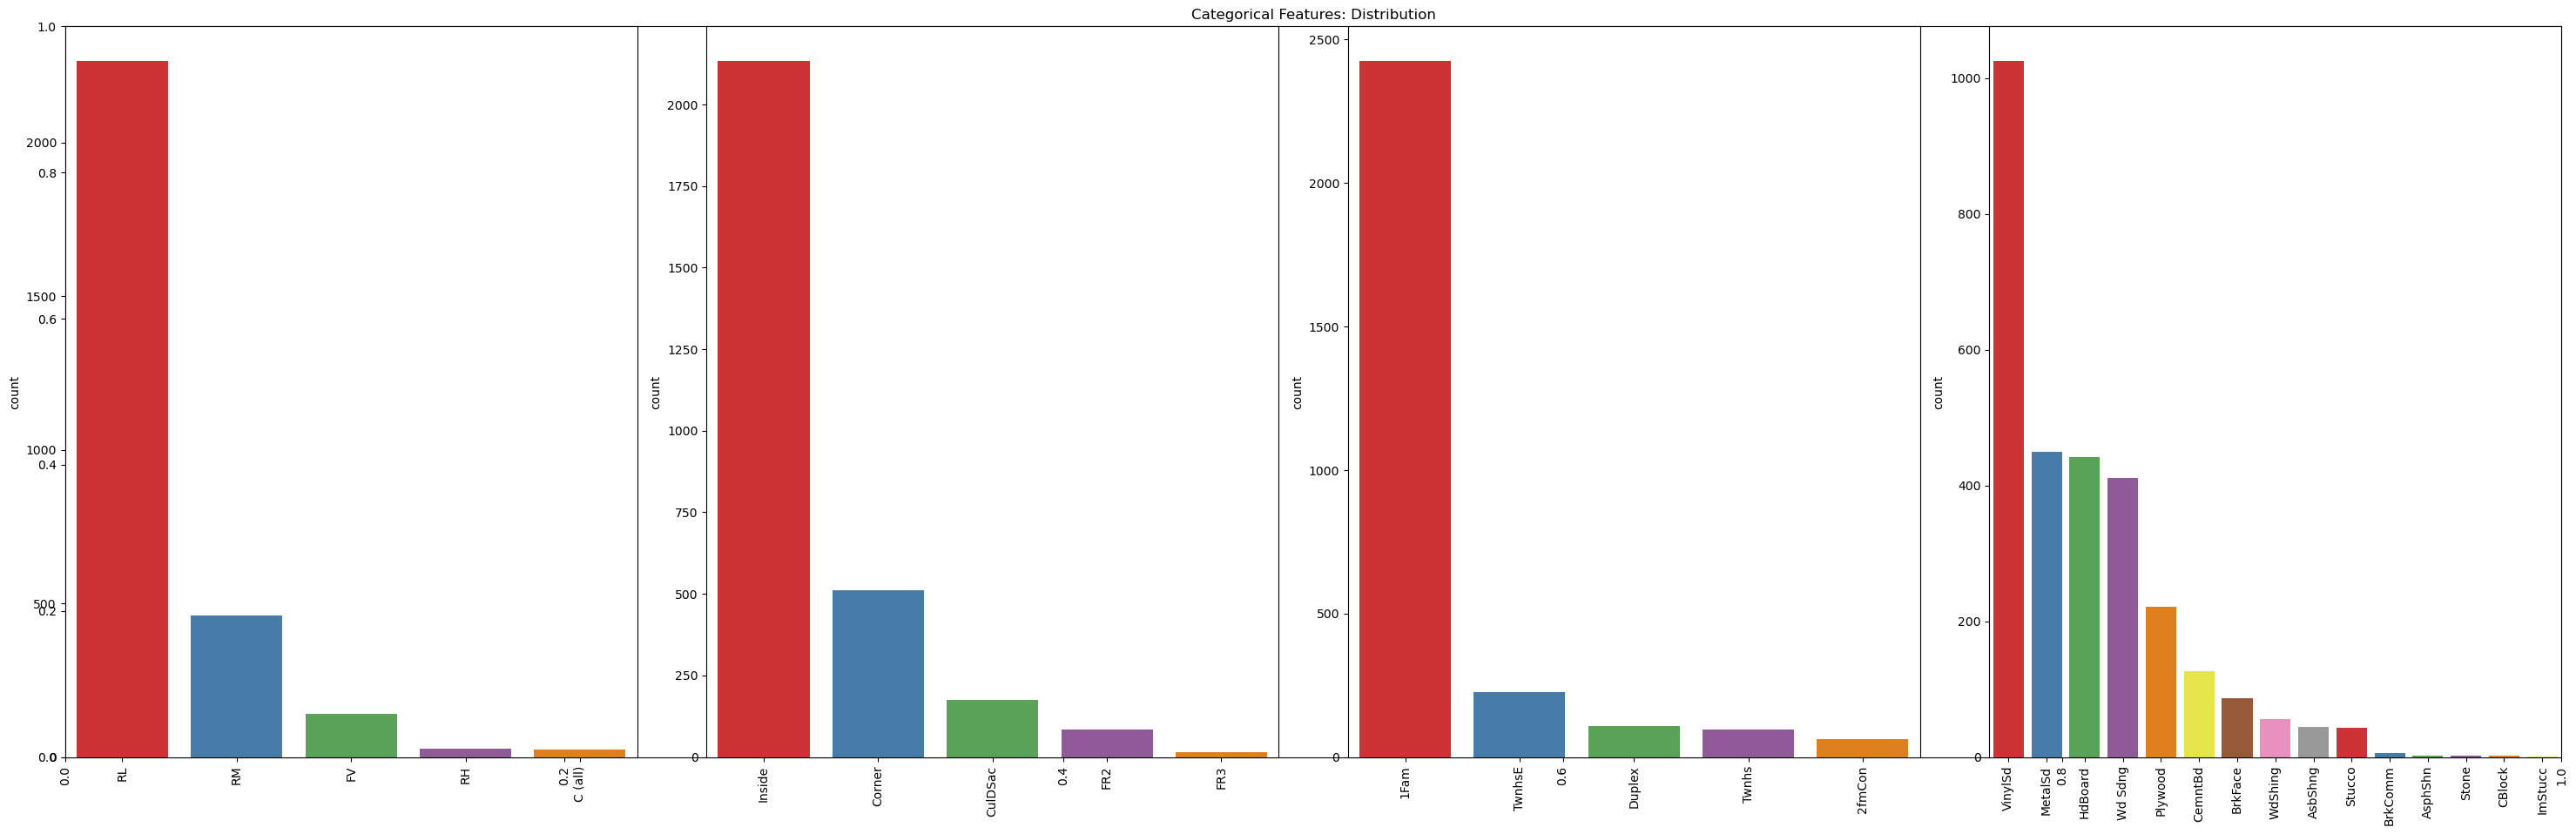

In [5]:
plt.figure(figsize=(30,10))
plt.title('Categorical Features: Distribution')
plt.xticks(rotation=90)
index = 1

for col in object_cols:
    y = dataset[col].value_counts()
    plt.subplot(1, 4, index)
    plt.xticks(rotation=90)
    sns.barplot(x=list(y.index), y=y, hue=list(y.index), palette='Set1', legend=False)
    index += 1

plt.tight_layout()
plt.savefig('../results/figures/edaDistribution.png', dpi=300, bbox_inches='tight')

plt.show()

In [6]:
# data cleaning to remove incorrect, corrupted or irrelevant data
dataset.drop(['Id'], axis=1, inplace=True)

# replace SalePrice empty values with mean to make distribution symmetric
dataset['SalePrice'] = dataset['SalePrice'].fillna(dataset['SalePrice'].mean())

# drop null values and check if there are any remaining in the new dataframe
new_dataset = dataset.dropna()
new_dataset.isnull().sum()

MSSubClass      0
MSZoning        0
LotArea         0
LotConfig       0
BldgType        0
OverallCond     0
YearBuilt       0
YearRemodAdd    0
Exterior1st     0
BsmtFinSF2      0
TotalBsmtSF     0
SalePrice       0
dtype: int64

In [7]:
# convert categorical data into binary vectors using OneHotEncoder (OHE) from sklearn
from sklearn.preprocessing import OneHotEncoder

s = (new_dataset.dtypes == 'object')
object_cols = list(s[s].index)
print(f'The categorical variables are {object_cols}.')
print(f'There are {len(object_cols)} categorical features.')

The categorical variables are ['MSZoning', 'LotConfig', 'BldgType', 'Exterior1st'].
There are 4 categorical features.


In [8]:
# apply OHE to whole list
OH_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
OH_cols = pd.DataFrame(OH_encoder.fit_transform(new_dataset[object_cols]))
OH_cols.index = new_dataset.index
OH_cols.columns = OH_encoder.get_feature_names_out()
df_final = new_dataset.drop(object_cols, axis=1)
df_final = pd.concat([df_final, OH_cols], axis=1)

In [9]:
# split data inot training and testing sets
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

X = df_final.drop(['SalePrice'], axis=1)
Y = df_final['SalePrice']

X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=0)

Check model accuracy using (1) a support vector machine, (2) a random forest regressor, and (3) a linear regressor and calculate loss using mean absolute percentage error

In [10]:
# svm - supervised ML algorithm used for classification or regression by finding the hyperplane that best divides the data
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import mean_absolute_percentage_error

model_SVR = svm.SVR()
model_SVR.fit(X_train, Y_train)
Y_pred = model_SVR.predict(X_valid)

print(f'The mean absolute perctage error is {mean_absolute_percentage_error(Y_valid, Y_pred) * 100:.3f}%')

The mean absolute perctage error is 18.705%


In [11]:
# random forest regression - ensemble learning algorithm for classification and regression, builds multiple decission trees
from sklearn.ensemble import RandomForestRegressor

model_RFR = RandomForestRegressor(n_estimators=10)
model_RFR.fit(X_train, Y_train)
Y_pred = model_RFR.predict(X_valid)

print(f'The mean absolute perctage error is {mean_absolute_percentage_error(Y_valid, Y_pred) * 100:.3f}%')

The mean absolute perctage error is 19.105%


In [12]:
# linear regression - models relationship between dependent and independent variables
from sklearn.linear_model import LinearRegression

model_LR = LinearRegression()
model_LR.fit(X_train, Y_train)
Y_pred = model_LR.predict(X_valid)

print(f'The mean absolute perctage error is {mean_absolute_percentage_error(Y_valid, Y_pred) * 100:.3f}%')

The mean absolute perctage error is 18.742%


Comparing the models, the random forest has the largest error and the SVM the smallest